In [1]:
import numpy as np
import os
import sys
import tensorflow as tf
from collections import OrderedDict
import re
from PIL import Image
from matplotlib import pyplot as plt
import matplotlib.patches as patches

print("Tensorflow version: {}".format(tf.__version__))

Tensorflow version: 1.11.0


# Environment

In [2]:
config = tf.ConfigProto()
#config.gpu_options.allow_growth = True
config.allow_soft_placement = True
config.log_device_placement=True
config.gpu_options.per_process_gpu_memory_fraction = 0.1

# Load Model and Graph

In [3]:
# =============================================================
# for a begineer, this is the only parameter you need to change
# =============================================================
your_own_model = False

In [4]:
"""
PB: the frozen model
pb.txt: the label map file
"""

if your_own_model:
    RETRAINED_MODEL_PATH = "./model"
    PATH_TO_PB = os.path.join(RETRAINED_MODEL_PATH, "frozen_inference_graph.pb")
    PATH_TO_LABELS = os.path.join(RETRAINED_MODEL_PATH, "label_map.pbtxt")
else:
    PRETRAINED_MODEL_PATH = "./ssd_mobilenet_v1_fruit"
    PATH_TO_PB = os.path.join(PRETRAINED_MODEL_PATH, "frozen_inference_graph.pb")
    PATH_TO_LABELS = os.path.join(PRETRAINED_MODEL_PATH, "label_map.pbtxt")

if not os.path.exists(PATH_TO_PB): raise FileNotFoundError("PB is not found.")
if not os.path.exists(PATH_TO_LABELS): raise FileNotFoundError("Label is not found")

## load frozen graph 

In [5]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_PB, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

## Show all operation names

In [6]:
def show_operation_names(count=10):
    """
    Show all operation names in the graph, including "input(image_tensor)" 
    and "output(detection_boxes, detection_scores, detection_classes, num_detections)".
    """
    with detection_graph.as_default():
        with tf.Session(config=config) as sess:
            opts = tf.get_default_graph().get_operations()
            for opt in opts[:count]: 
                for output in opt.outputs: print(output.name)
            print("...")
            for opt in opts[-count:]: 
                for output in opt.outputs: print(output.name)
                    
show_operation_names(5)

Const:0
image_tensor:0
ToFloat:0
Preprocessor/map/Shape:0
Preprocessor/map/strided_slice/stack:0
...
add:0
detection_boxes:0
detection_scores:0
detection_classes:0
num_detections:0


## Load Label file

In [7]:
category_index = OrderedDict()
with open(PATH_TO_LABELS, "r") as fin:
    tmpData = ""
    for line in fin:
        tmpData += line.strip()
    #print(tmpData)
    
    pattern = re.compile("item\s+\{id:\s+(\d*)name:\s+'([\d\S]*)'\}", re.I)
    allItems = pattern.findall(tmpData)
    for item_idx in range(len(allItems)):
        category_index[int(allItems[item_idx][0])] = {'id': int(allItems[item_idx][0]), \
                                                      'name': str(allItems[item_idx][1])}
    print(category_index)

OrderedDict([(1, {'name': 'Orange', 'id': 1}), (2, {'name': 'Lemon', 'id': 2}), (3, {'name': 'Apple', 'id': 3})])


## load image data

In [8]:
def load_image_into_nparray(image):
    (img_width, img_height) = image.size
    return np.array(image.getdata()).reshape(img_height, img_width, 3).astype(np.uint8)

# Inference 

In [9]:
def inference_single_image(image, graph):
    """
    image `image_tensor`: data in type uint8 of shape [None, None, None, 3]
    graph: loaded from frozen model file
    `num_detections`: shape [batch] in float32, the number of valid box per images
    `detection_boxes`: shape [batch, box_number, 4] in float32, (ymin, xmin, ymax, xmax)
    `detection_scores`: shape [batch, box_number] in float32, class scores for each box detections
    `detection_classes`: shape [batch, box_number] in float32, classes for each box detections
    """
    with graph.as_default():
        with tf.Session(config=config) as sess:
            # handle input and output tensor
            opts = tf.get_default_graph().get_operations()
            all_tensorflow_names = { output.name for opt in opts for output in opt.outputs }
            tensor_dict = {}
            for key in ['num_detections', 'detection_boxes', 'detection_scores', 'detection_classes']:
                tensor_name = key + ':0'
                if tensor_name in all_tensorflow_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(tensor_name)
                    
            # run for single image            
            # input
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')
            
            # inference
            output_dict = sess.run(tensor_dict, feed_dict={image_tensor: np.expand_dims(image, 0)})
            
            # convert data type float32 to appropriate
            output_dict['num_detections'] = int(output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict['detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
                
        return output_dict

## Plot

In [10]:
def calculateCoord(imgPath, points):
    # (ymin, xmin, ymax, xmax)
    (h, w) = plt.imread(imgPath).shape[:2]
    y1, x1 = h * points[0], w * points[1]
    y2, x2 = h * points[2], w * points[3]
    return int(round(x1)), int(round(y1)), int(round(x2)), int(round(y2))

In [11]:
def showImage(imgPath, points, class_res):
    im = plt.imread(imgPath)
    
    fig,ax = plt.subplots(1, 1, figsize=(12,8))

    # Display the image
    ax.imshow(im)
    
    color = {'Apple':'r','Lemon':'g','Orange':'b'}
    color_text = {'Apple':'red','Lemon':'green','Orange':'blue','default':'white'}

    # Create a Rectangle patch
    for point in range(len(points)):
        rect = patches.Rectangle((points[point][0], points[point][1]),\
                                 points[point][2]- points[point][0],\
                                 points[point][3]- points[point][1],\
                                 linewidth=3,\
                                 edgecolor=color[class_res[point][0]],\
                                 facecolor='none')
        
        # Add the patch to the Axes
        ax.add_patch(rect)
    
    for point in range(len(points)):
        x = points[point][0]
        y = points[point][1]
        s = "{}:{}".format(class_res[point][0], class_res[point][1])
        plt.text(x, y, s, fontdict=dict(fontsize=14, color=color_text["default"]), \
                 bbox=dict(facecolor=color_text[class_res[point][0]], alpha=0.1))
    
    plt.show()

# Detection / Inference

Here we use the image from unsplash (https://unsplash.com/) and example images are photoed by `Grant Ritchie` and `Charl van Rooy`.

* image1.jpg: Photo by Grant Ritchie on Unsplash
* image2.jpg: Photo by Charl van Rooy on Unsplash

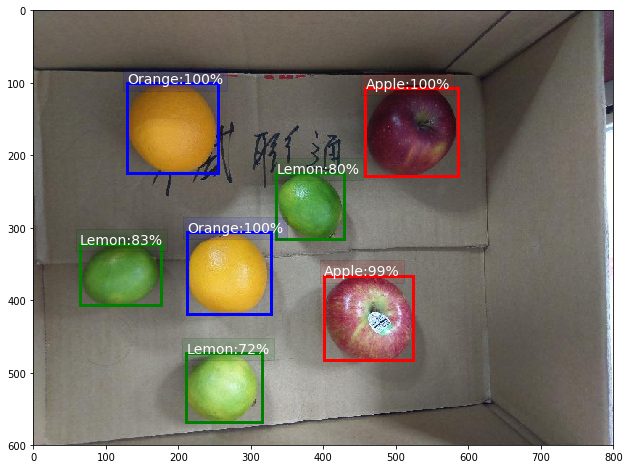

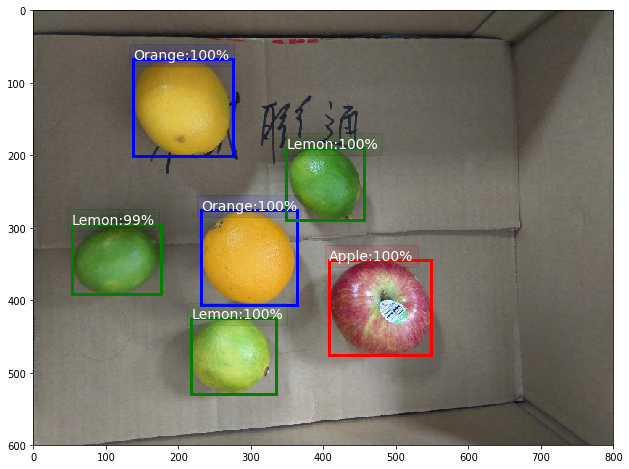

In [12]:
if __name__ == "__main__":

    if your_own_model:
        PATH_TO_TEST_IMAGES_DIR = "./data/test_images/"
    else:
        PATH_TO_TEST_IMAGES_DIR = "./ssd_mobilenet_v1_fruit/test_images/"
    assert os.path.exists(PATH_TO_TEST_IMAGES_DIR), "Test image folder is not found."
    
    fileNames = next(os.walk(PATH_TO_TEST_IMAGES_DIR))[2]
    
    for img in fileNames:
        image_path = os.path.join(PATH_TO_TEST_IMAGES_DIR, img)
        if not os.path.exists(image_path): raise FileNotFoundError("{} not found.".format(image_path))

        image = Image.open(image_path)   # (width, height)
        image_np = load_image_into_nparray(image)   # reshape to (height, width, 3)
        output_dict = inference_single_image(image_np, detection_graph)

        threshold = 5e-1
        odList = np.argwhere(output_dict['detection_scores'] > threshold)   # select highly confident
        odList = odList.reshape(-1)

        point_list = []
        class_res = []
        for odidx in odList:
            point_list.append(calculateCoord(image_path, output_dict['detection_boxes'][odidx]))
            class_res.append([\
                              "{}".format(category_index[output_dict['detection_classes'][odidx]]['name']),\
                              "{}".format(str(int(round(output_dict['detection_scores'][odidx]*100, 0))) + "%")\
                             ])

        showImage(image_path, point_list, class_res)